# Modélisation de la prédiction de tags pour les posts de Stack Overflow

Ce notebook regroupe les travaux de prétraitement des docuements et les tests des modèles des approches supervisés et non supervisés afin de prédire les tags des posts de Stack Overflow.

## Contexte

Afin de permettre de faciliter le parcours des utilisateurs de l'outil communautaire Stack Overflow nous avons travaillé sur la mise à disposition d'une API de suggestion de tags.

## Importation des données

Pour les besoins du notebook nous ne conservons que les titres, corps du texte et tags des document importés. 

In [1]:
import pandas as pd
import numpy as np
import IPython.display

data = pd.read_csv('./data/filtered_data.csv', usecols=['Id','Title', 'Body', 'Tags'], index_col='Id')
data.reset_index(inplace=True)
data.drop(columns='Id', inplace=True)
data.head(10)

,Title,Body,Tags
0,Support for password authentication was remove...,<p>I got this error on my console when I tried...,<git><github><github-api><git-pull><personal-a...
1,"How can I deal with this Git warning? ""Pulling...",<p>After a <code>git pull origin master</code>...,<git>
2,"Xcode building for iOS Simulator, but linking ...",<p>I am trying to get a large (and working on ...,<ios><xcode><xcode12><xcode12beta5><xcode12beta6>
3,"Error message ""error:0308010C:digital envelope...",<p>I created the default IntelliJ IDEA React p...,<node.js><reactjs><webpack><webstorm>
4,Attempted import error: 'Switch' is not export...,<p>I don't know why I am getting this error an...,<reactjs>
5,Unable to resolve dependency tree error when i...,<p>When trying to install the npm packages usi...,<angularjs><angular><typescript><npm><angular9>
6,"Android Studio error ""Installed Build Tools re...",<p>I'm on Android Studio 4.2.2. I created a ne...,<android><android-studio><android-emulator><an...
7,No Firebase App '[DEFAULT]' has been created -...,<p>I am building a Flutter application and I h...,<firebase><flutter><android-studio><dart><goog...
8,"OnActivityResult method is deprecated, what is...",<p>I recently discovered that <code>onActivity...,<android><android-fragments><android-activity>...
9,`npm install` fails on node-gyp rebuild with `...,<p>Every time I try <code>npm install</code>. ...,<node.js><npm><terminal><macos-catalina><node-...


## Pré-traitement

### Constitution du corpus 

Nous commençons par créer une nouvelle variable associant le titre (Title) et le corps du texte (Body)

In [2]:
%%time
data['Post'] = data.apply(lambda x: x['Title'] + ' ' + x['Body'] if x['Title'] == x['Title'] else x['Body'], axis=1)
corpus = data['Post'].to_list()
tags = data['Tags'].to_list()

print("Dix première observations")
display(data.head(10))

print("Premier élément de la liste corpus\n")
display(corpus[0])
print("\n")

print("Premier éléments de la liste tags\n")
display(tags[0])

print(f"Occurences dans le corpus: {len(corpus)}")
print(f"Occurences dans les tags: {len(tags)}")

Dix première observations


,Title,Body,Tags,Post
0,Support for password authentication was remove...,<p>I got this error on my console when I tried...,<git><github><github-api><git-pull><personal-a...,Support for password authentication was remove...
1,"How can I deal with this Git warning? ""Pulling...",<p>After a <code>git pull origin master</code>...,<git>,"How can I deal with this Git warning? ""Pulling..."
2,"Xcode building for iOS Simulator, but linking ...",<p>I am trying to get a large (and working on ...,<ios><xcode><xcode12><xcode12beta5><xcode12beta6>,"Xcode building for iOS Simulator, but linking ..."
3,"Error message ""error:0308010C:digital envelope...",<p>I created the default IntelliJ IDEA React p...,<node.js><reactjs><webpack><webstorm>,"Error message ""error:0308010C:digital envelope..."
4,Attempted import error: 'Switch' is not export...,<p>I don't know why I am getting this error an...,<reactjs>,Attempted import error: 'Switch' is not export...
5,Unable to resolve dependency tree error when i...,<p>When trying to install the npm packages usi...,<angularjs><angular><typescript><npm><angular9>,Unable to resolve dependency tree error when i...
6,"Android Studio error ""Installed Build Tools re...",<p>I'm on Android Studio 4.2.2. I created a ne...,<android><android-studio><android-emulator><an...,"Android Studio error ""Installed Build Tools re..."
7,No Firebase App '[DEFAULT]' has been created -...,<p>I am building a Flutter application and I h...,<firebase><flutter><android-studio><dart><goog...,No Firebase App '[DEFAULT]' has been created -...
8,"OnActivityResult method is deprecated, what is...",<p>I recently discovered that <code>onActivity...,<android><android-fragments><android-activity>...,"OnActivityResult method is deprecated, what is..."
9,`npm install` fails on node-gyp rebuild with `...,<p>Every time I try <code>npm install</code>. ...,<node.js><npm><terminal><macos-catalina><node-...,`npm install` fails on node-gyp rebuild with `...


Premier élément de la liste corpus



'Support for password authentication was removed. Please use a personal access token instead <p>I got this error on my console when I tried to use <code>git pull</code>:</p>\n<blockquote>\n<p>remote: Support for password authentication was removed on August 13, 2021. Please use a personal access token instead.<br />\nremote: Please see <a href="https://github.blog/2020-12-15-token-authentication-requirements-for-git-operations/" rel="noreferrer">https://github.blog/2020-12-15-token-authentication-requirements-for-git-operations/</a> for more information.<br />\nfatal: unable to access &quot;...&quot; : The requested URL returned error: 403</p>\n</blockquote>\n<p>It\'s very weird, because I just followed the documentation and created a token two weeks ago on GitHub. The token expires on Tue, Oct 26, 2021. Why has this been removed today?</p>\n'



Premier éléments de la liste tags



'<git><github><github-api><git-pull><personal-access-token>'

Occurences dans le corpus: 18821
Occurences dans les tags: 18821
CPU times: total: 719 ms
Wall time: 730 ms


### Nettoyage HTML

Nous constatons que les contenus importés comportent un nombre importante de balise HTML. Nous créeons une fonction afin de les retirer.

In [3]:
%%time

def clean_html(text):
    """
    Remove HTML from a text.
    
    Args:
        text(String): Row text with html 
             
    Returns:
        cleaned String
    """
    import lxml
    import html5lib
    from bs4 import BeautifulSoup
 
    soup = BeautifulSoup(text, "html5lib")

    for sent in soup(['style', 'script']):
            sent.decompose()
   
        
    return ' '.join(soup.stripped_strings)

corpus_wo_html = [clean_html(text) for text in corpus]

print("Premier élément de la liste corpus sans html\n")
display(corpus_wo_html[0])
print("\n")

print(f"Occurences dans le corpus: {len(corpus_wo_html)}")

Premier élément de la liste corpus sans html



'Support for password authentication was removed. Please use a personal access token instead I got this error on my console when I tried to use git pull : remote: Support for password authentication was removed on August 13, 2021. Please use a personal access token instead. remote: Please see https://github.blog/2020-12-15-token-authentication-requirements-for-git-operations/ for more information. fatal: unable to access "..." : The requested URL returned error: 403 It\'s very weird, because I just followed the documentation and created a token two weeks ago on GitHub. The token expires on Tue, Oct 26, 2021. Why has this been removed today?'



Occurences dans le corpus: 18821
CPU times: total: 1min 24s
Wall time: 1min 24s


### Nettoyage du texte

Pour les besoin des traitemment futurs et entrainements des modèles, nous avons besoins de passer les textes en minuscule. Nous en profitons pour ne conserver que les caractères alphabétiques et ne garder que les termes de plus de trois lettres. Le filtrage sur la taille des termes permet de retirer ceux qui sont générique liés au code (if, for …). Il  reste toutefois perfectible puisqu’il élimine les occurrences de certains langages (C, C++, C#, R… ). 

In [4]:
%%time

def text_cleaning(text):
    """
    Remove figures, punctuation, words shorter than two letters (excepted C or R) in a lowered text. 
    
    Args:
        text(String): Row text to clean
        
    Returns:
       res(string): Cleaned text
    """
    import re
    
    pattern = re.compile(r'[^\w]|[\d_]')
    
    try: 
        res = re.sub(pattern," ", text).lower()
    except TypeError:
        return text
    
    res = res.split(" ")
    res = list(filter(lambda x: len(x)>3 , res))
    res = " ".join(res)
    return res

cleaned_corpus = [text_cleaning(text) for text in corpus_wo_html]
cleaned_tags = [text_cleaning(text).strip() for text in tags]


print("Premier élément de la liste cleaned_corpus\n")
display(cleaned_corpus[0])
print("\n")

print("Premier élément de la liste cleaned_tags\n")
display(cleaned_tags[0])
print("\n")

print(f"Occurences dans le corpus nettoyé: {len(cleaned_corpus)}")
print(f"Occurences dans les tags nettoyés: {len(cleaned_tags)}")

Premier élément de la liste cleaned_corpus



'support password authentication removed please personal access token instead this error console when tried pull remote support password authentication removed august please personal access token instead remote please https github blog token authentication requirements operations more information fatal unable access requested returned error very weird because just followed documentation created token weeks github token expires this been removed today'



Premier élément de la liste cleaned_tags



'github github pull personal access token'



Occurences dans le corpus nettoyé: 18821
Occurences dans les tags nettoyés: 18821
CPU times: total: 9.08 s
Wall time: 9.11 s


### Tokenization

La tokenisation permet de transformer les textes passés en entrée en liste de termes distincts (token).  Pendant le traitement les termes génériques (stop words) ne sont pas conservés dans la liste des tokens.

In [5]:
%%time
def tokenize(text):
    """
    Tokenize words of a text.
    
    Args:
    
        text(String): Row text
        
    Returns
    
        res(list): Tokenized string.
    """
    
    from nltk.corpus import stopwords
    from nltk import word_tokenize
    from nltk.tokenize import sent_tokenize

    stop_words = set(stopwords.words('english'))
    
    try:
        res = word_tokenize(text, language='english')
    except TypeError:
        return text
    
    res = [token for token in res if token not in stop_words]
    return res

tokenized_corpus = [tokenize(text) for text in cleaned_corpus]
tokenized_tags = [tokenize(text) for text in cleaned_tags]

print("Premier élément de la liste tokenized_corpus\n")
display(tokenized_corpus[0])
print("\n")
print(f"Longueur du premier éléments de liste tokenized_corpus: {len(tokenized_corpus[0])}")
print("\n")

print("Premier élément de la liste tokenized_tags\n")
display(tokenized_tags[0])
print('\n')


print(f"Occurences dans le corpus tokenizé: {len(tokenized_corpus)}")
print(f"Occurences dans la liste des tags: {len(tokenized_tags)}")

Premier élément de la liste tokenized_corpus



['support',
 'password',
 'authentication',
 'removed',
 'please',
 'personal',
 'access',
 'token',
 'instead',
 'error',
 'console',
 'tried',
 'pull',
 'remote',
 'support',
 'password',
 'authentication',
 'removed',
 'august',
 'please',
 'personal',
 'access',
 'token',
 'instead',
 'remote',
 'please',
 'https',
 'github',
 'blog',
 'token',
 'authentication',
 'requirements',
 'operations',
 'information',
 'fatal',
 'unable',
 'access',
 'requested',
 'returned',
 'error',
 'weird',
 'followed',
 'documentation',
 'created',
 'token',
 'weeks',
 'github',
 'token',
 'expires',
 'removed',
 'today']



Longueur du premier éléments de liste tokenized_corpus: 51


Premier élément de la liste tokenized_tags



['github', 'github', 'pull', 'personal', 'access', 'token']



Occurences dans le corpus tokenizé: 18821
Occurences dans la liste des tags: 18821
CPU times: total: 48.2 s
Wall time: 48.5 s


NLTK propose des listes de stop words génériques. Nous attirons  l’attention sur le fait que le corpus utilisé pour les travaux est de nature spécifique. En effet les posts contiennent souvent du code, des messages d’erreur de compilateurs / interpréteurs ou des logs alors qu’aucune liste de stop words mis à disposition ne porte sur le thématique. Le risque est de laisser passer des termes génériques vis-à-vis du contexte étudié. Sans allouer un important temps de travail il s’avère difficile de construire une liste de stop words spécifique exhaustive. 

### Filtrage des noms à l'aide d'un modèle de POS tagging

Lors de pré-traitement des posts nous cherchons avant tout à identifier à termes liés à des technologies utilisées. Ces dernières sont généralement des noms. Afin de mettre en œuvre le filtrage nous utilisons un modèle de POS. Ce dernier se base sur des chaînes de Markov . Leur principe est d’identifier la probabilité  la plus forte de la fonction grammaticale d’un terme par rapport :
- la fonction grammaticale du terme précédent 
- A la probabilité la plus forte de l’association entre le terme et une fonction grammaticale particulière


In [6]:
%%time 
def filtering_nouns(tokens):
    """
    Filter singular nouns
    
    Args:
        tokens(list): A list o tokens
        
    
    Returns:
    
        res(list): Filtered token list
    """ 
    
    import nltk
    
    res = nltk.pos_tag(tokens)
    
    res = [token[0] for token in res if token[1] == 'NN']
    
    return res

noun_corpus = [filtering_nouns(tokens) for tokens in tokenized_corpus]

print("Premier élément de la liste noun_corpus\n")
display(noun_corpus[0])
print("\n")

print(f"Longueur du premier éléments de liste noun_corpus: {len(noun_corpus[0])}")
print("\n")


print(f"Occurences dans le corpus tokenizé: {len(noun_corpus)}")

Premier élément de la liste noun_corpus



['support',
 'password',
 'authentication',
 'access',
 'console',
 'support',
 'password',
 'authentication',
 'please',
 'access',
 'please',
 'https',
 'github',
 'blog',
 'authentication',
 'information',
 'fatal',
 'access',
 'documentation',
 'today']



Longueur du premier éléments de liste noun_corpus: 20


Occurences dans le corpus tokenizé: 18821
CPU times: total: 5min 8s
Wall time: 5min 9s


Nous attirons une nouvelle fois l’attention sur le fait que le corpus utilisé pour les travaux est de nature spécifique. Aucun corpus mis à disposition par NLTK ne couvre le domaine étudié. Le risque est que certaines technologies, dont la dénomination ne découle pas d’un nom commun, ne soient pas retenues par  le filtre.

### Lemmatisation

Afin d’éviter d’utiliser de multiples déclinaisons d’un même terme (conjugaisons, féminin, pluriel …). Les deux méthodes les couramment utilisées sont le stemming et la lemmatisation. Elles consistent toutes deux à dédupliquer les déclinaisons de termes en ne conservant que leur racine. Le stemming procède par troncature simple. De manière générale cette méthode peut poser un problème car plusieurs mots termes sémantiquement différents peuvent avoir la même racine (stem). La lemmatisation  consiste à identifier la racine sémantique (lemme) d’un terme référencé dans un corpus ou un dictionnaire d’une langue. Cette méthode évite, a priori, l’écueil de diminuer le nombre de termes ayant un stem identique mais des lemmes différents. Nous retenons donc la lemmatisation.  Par contre une fois encore nous sommes confrontés à la généricité des outils mis à disposition par NLTK. A titre d’exemple, “keras” (Framework de deep learning) devient “kera” une fois lemmatisé.

In [7]:
%%time
def lemmatization(tokens):
    """
    Transform tokens into lems 
    
    Args:
        tokens(list): List of tokens
        
    Returns:
        lemmatized(list): List of lemmatized tokens
    """
    import nltk
    from nltk.stem import WordNetLemmatizer
    
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    
    for token in tokens:
        lemmatized.append(lemmatizer.lemmatize(token))
        
    return lemmatized

lemmatized_corpus = [lemmatization(tokens) for tokens in noun_corpus]
lemmatized_tags = [lemmatization(tokens) for tokens in tokenized_tags]

tags_wo_blanks = []
for tokens in lemmatized_tags:
    tokens = [token for token in tokens if len(token)>1]
    tags_wo_blanks.append(tokens)

print("Premier élément de la liste lemmatized_corpus\n")
display(lemmatized_corpus[0])
print("\n")

print(f"Longueur du premier éléments de liste lemmatized_corpus: {len(lemmatized_corpus[0])}")
print("\n")

print("Premier élément de la liste lemmatized_tags\n")
display(tags_wo_blanks[0])


print(f"Occurences dans le corpus lemmatisé: {len(lemmatized_corpus)}")
print(f"Occurences dans les tags lemmatisés: {len(tags_wo_blanks)}")

Premier élément de la liste lemmatized_corpus



['support',
 'password',
 'authentication',
 'access',
 'console',
 'support',
 'password',
 'authentication',
 'please',
 'access',
 'please',
 'http',
 'github',
 'blog',
 'authentication',
 'information',
 'fatal',
 'access',
 'documentation',
 'today']



Longueur du premier éléments de liste lemmatized_corpus: 20


Premier élément de la liste lemmatized_tags



['github', 'github', 'pull', 'personal', 'access', 'token']

Occurences dans le corpus lemmatisé: 18821
Occurences dans les tags lemmatisés: 18821
CPU times: total: 13.6 s
Wall time: 13.7 s


### Filtrage des valeurs vides

Les premiers traitements on généré des docuements vides. Nous décidons de filtrer le corpus pour les éliminer.

In [8]:
print(f"Observations restante du corpus original: {data.shape[0]}")

joined_corpus = [" ".join(text) for text in lemmatized_corpus]
corpus_df = pd.DataFrame(joined_corpus, columns=['preprocessed_text'])
corpus_df['len_text'] = corpus_df['preprocessed_text'].apply(lambda x: len(x))

joined_tags = [" ".join(tags) for tags in tags_wo_blanks]
tag_df = pd.DataFrame(joined_tags, columns=['preprocessed_tags'])
tag_df['len_tags'] = tag_df['preprocessed_tags'].apply(lambda x: len(x))

corpus_tag_df = pd.concat([corpus_df, tag_df], axis=1)

empty_data_idx = corpus_tag_df[(corpus_tag_df['len_text']==0) | (corpus_tag_df['len_tags']==0)].index

corpus_tag_df.drop(index=empty_data_idx, inplace=True)
data.drop(index=empty_data_idx, inplace=True)

print(f"observations restantes du corpus traité: {corpus_tag_df.shape[0]}")

corpus_tag_df['splitted_text'] = corpus_tag_df['preprocessed_text'].apply(lambda x: x.split(' ') )
corpus_tag_df['splitted_tags'] = corpus_tag_df['preprocessed_tags'].apply(lambda x: x.split(' ') )

filtered_corpus = corpus_tag_df['splitted_text'].to_list()
filtered_tags = corpus_tag_df['splitted_tags'].to_list()
filtered_original_posts = data['Post'].to_list()

filtered_tokenized_vs_original = pd.concat([data['Post'],
                                            corpus_tag_df['splitted_text'], 
                                            corpus_tag_df['splitted_tags']],
                                            axis=1)

filtered_tokenized_vs_original.to_csv("./data/cleaned_corpus.csv", index=False)
filtered_tokenized_vs_original.to_pickle('./data/cleaned_corpus.pkl')

filtered_tokenized_vs_original.head(10)

Observations restante du corpus original: 18821
observations restantes du corpus traité: 18599


,Post,splitted_text,splitted_tags
0,Support for password authentication was remove...,"[support, password, authentication, access, co...","[github, github, pull, personal, access, token]"
2,"Xcode building for iOS Simulator, but linking ...","[xcode, building, simulator, file, architectur...","[xcode, xcode, xcode, beta, xcode, beta]"
3,"Error message ""error:0308010C:digital envelope...","[error, message, error, envelope, default, int...","[node, reactjs, webpack, webstorm]"
4,Attempted import error: 'Switch' is not export...,"[import, error, switch, router, error, answer,...",[reactjs]
5,Unable to resolve dependency tree error when i...,"[resolve, dependency, error, installing, insta...","[angularjs, angular, typescript, angular]"
6,"Android Studio error ""Installed Build Tools re...","[studio, error, revision, studio, project, any...","[android, android, studio, android, emulator, ..."
7,No Firebase App '[DEFAULT]' has been created -...,"[firebase, default, firebase, initializeapp, f...","[firebase, flutter, android, studio, dart, goo..."
8,"OnActivityResult method is deprecated, what is...","[onactivityresult, method, onactivityresult, a...","[android, android, fragment, android, activity..."
9,`npm install` fails on node-gyp rebuild with `...,"[install, version, time, install, error, versi...","[node, terminal, macos, catalina, node]"
10,TypeError: this.getOptions is not a function <...,"[typeerror, error, bootstrap, error, online, n...","[webpack, sas, loader]"


### Fréquence de distribution tokens

Nous observons à présent la fréquence de distribution des tokens.

In [9]:
%%time
def build_word_distribution(corpus):
    """
    Build corpus word distribution
    
    Args:
        Corpus(List of lists): Original corpus
    
    Returns:
        
        word_dist_df(DataFrame): Word distribution of the corpus
    """
    
    from nltk import FreqDist
    word_corpus = [token for token_list in corpus for token in token_list]
    word_dist = FreqDist(word_corpus)
    word_dist_df = pd.DataFrame(word_dist.items(), columns=['Word', 'Frequency']).set_index('Word')
    word_dist_df.sort_values("Frequency", ascending=False, inplace=True)

    return word_dist_df

word_dist = build_word_distribution(filtered_corpus)

print(f"Nombre de tokens du corpus {word_dist.shape[0]}")
print("Affichage des 20 tokens les plus utilisés")
display(word_dist.head(20))

Nombre de tokens du corpus 65060
Affichage des 20 tokens les plus utilisés


,Frequency
Word,
error,21798
java,18797
file,14427
import,14177
name,13849
version,12759
code,11539
http,11237
class,10976


CPU times: total: 1.67 s
Wall time: 1.66 s


Nous constatons un nombre important de termes génériques tels que : error, class, value, return ...

### Fréquence de distribution des tags

Nous réalisons le même traitement sur les tags.

In [10]:
tag_dist = build_word_distribution(filtered_tags)
print("Top 20 des tags les plus utilisés")
display(tag_dist.head(20))
print(f"Nombre de tags: {len(tag_dist)}")
first_200_tags = tag_dist[0:200].index.to_list()

Top 20 des tags les plus utilisés


,Frequency
Word,
python,3701
android,2789
javascript,2092
reactjs,1912
react,1531
flutter,1464
java,1225
studio,1108
docker,1025


Nombre de tags: 4302


### filtrage top 200 tags

Pour les besoin des entrainements des modèles supervisés, nous avons besoin limiter le nombre de tags. Nous décidons de ne retenir que les 200 premiers.Du nous avons du à nouveau filtrer les documents qui ne sont pas liés aux 200 premiers tags.

In [11]:
print(f"Observations restantes dans le corpus original: {data.shape[0]}")
filtered_corpus_tag_df = corpus_tag_df.copy()
filtered_corpus_tag_df['tags_in_top200'] = filtered_corpus_tag_df['splitted_tags'].apply(lambda tags: [tag for tag in tags if tag in first_200_tags])

filtered_corpus_tag_df['len_tags_in_top200'] = filtered_corpus_tag_df['tags_in_top200'].apply(lambda x: len(x))
missing_filtered_data = filtered_corpus_tag_df[filtered_corpus_tag_df['len_tags_in_top200'] == 0].index

filtered_corpus_tag_df.drop(index=missing_filtered_data, inplace=True)
data.drop(index=missing_filtered_data, inplace=True)
print(f"Observations restantes dans le coprus traité: {filtered_corpus_tag_df.shape[0]}")

top200_corpus = filtered_corpus_tag_df['splitted_text'].to_list()
top200_joined_corpus = filtered_corpus_tag_df['preprocessed_text'].to_list()
top200_tags = filtered_corpus_tag_df['tags_in_top200'].to_list()

Observations restantes dans le corpus original: 18599
Observations restantes dans le coprus traité: 17517


### Fréquences de distribution des tokens après filtrage du top 200 tags

Nous souhaitons à nouveau appréhender la distribution des tokens sur le corpus filtré.

In [12]:
word_dist_top200 = build_word_distribution(top200_corpus)
print(f"Nombre de tokens du corpus {word_dist_top200.shape[0]}")
print("Affichage des 20 tokens les plus utilisés")
display(word_dist_top200.head(20))
print("Nombre des tokens ayant plus de 1000 occurences sur le corpus filtré")
word_dist_top200[word_dist_top200["Frequency"]>=1000].shape[0]

Nombre de tokens du corpus 62025
Affichage des 20 tokens les plus utilisés


,Frequency
Word,
error,20696
java,18354
import,13976
file,13815
name,13307
version,12101
code,10925
http,10734
class,10580


Nombre des tokens ayant plus de 1000 occurences sur le corpus filtré


239

Nous constaton que le filtrage par top 200 tags a changé le classement des tokens les plus représenté. De plus un filtrage par fréquence des token a drastiquement le nombre de tokens retenus.

### Fréquences de distribution des tags après filtrage du top 200 tags

Nous réalisons le même traitement sur les tags.

In [13]:
tag_dist_top_200 = build_word_distribution(top200_tags)
print("Top 20 des tags les plus utilisés")
display(tag_dist_top_200.head(20))
print(f"Nombre de tags: {len(tag_dist_top_200)}")

Top 20 des tags les plus utilisés


,Frequency
Word,
python,3701
android,2789
javascript,2092
reactjs,1912
react,1531
flutter,1464
java,1225
studio,1108
docker,1025


Nombre de tags: 200


### TF-IDF

Afin de pouvoir entraîner les modèles nous avons besoin de transformer les listes de tokens lemmatisés en vecteurs. Deux méthodes sont couramment utilisées :
- Bag of words : Chaque liste de token (appelée document) est transformée en un vecteur indiquant la fréquence brute de chaque terme du corpus dans la liste. 
- TF-IDF : Dans cette méthode, la fréquence brute d’un token  est remplacée par un indicateur composé de sa fréquence d’apparition du token dans le document et la fréquence inverse du nombre de documents où le token apparaît. Tel que TF-IDF=TF ×log⁡〖|D|/|{d_j ∶ t_i∈d_j }| 〗 avec |D| : le nombre total de documents dans le corpus et |{d_j ∶ t_i∈d_j }| : le nombre de documents ou le token apparaît. Cette méthode permet de minorer les tokens présents dans un nombre élevé de documents et de normaliser la taille des documents. 
Les documents contenant des termes très génériques et de longueurs très variables, nous avons décidé d’utiliser une vectorisation par TF-IDF pour la suite des travaux. Afin de de ne garder que les tokens les plus représentatifs, nous avons entrainé les modèles de vectorisation sur des dictionnaire de correspondance (vocabulary) ne comportant que des termes dont la fréquence est supérieure à 1000 occurrences dans le corpus.

In [14]:
import pickle

In [15]:

%%time
from sklearn.feature_extraction.text import TfidfVectorizer
vocabulary = list(word_dist_top200[word_dist_top200["Frequency"]>=1000].index)
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary)
X = tfidf_vectorizer.fit_transform(top200_joined_corpus)
tfidf_data = pd.DataFrame(X.toarray(), columns=vocabulary)
print("Affichage des 10 premiers posts vectorisés via le modèle de TF-IDF")
display(tfidf_data.head(10))
print(f" Nombre d'observations: {tfidf_data.shape[0]}, nombre de variables: {tfidf_data.shape[1]}")

filename_tfidf_model = './models/tfidf_model.pkl'
pickle.dump(tfidf_vectorizer, open(filename_tfidf_model, 'wb'))

filename_vocabulary = "./models/vocabulary.pkl"
pickle.dump(vocabulary, open(filename_vocabulary, 'wb'))

Affichage des 10 premiers posts vectorisés via le modèle de TF-IDF


,error,java,import,file,name,version,code,http,class,python,...,null,window,pas,androidx,loss,render,screen,document,scala,account
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.131632,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.250326,0.0,0.000000,0.321832,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.178157,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.155747,0.0,0.438626,0.000000,0.0,0.000000,0.086517,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.332952,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.221629,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.142333,0.0,0.000000,0.000000,0.0,0.388253,0.079066,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.016161,0.000000,0.041632,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.218544,0.0,0.000000,0.000000,0.0,0.372587,0.060700,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.187290,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.083113,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 Nombre d'observations: 17517, nombre de variables: 239
CPU times: total: 1.67 s
Wall time: 1.72 s


## Entrainement des modèles en approche supervisée.

### Dédoublonnage des labels

Le dédoublonnage des tags – label s’avère nécessaire après le pré-traitement des documents. En effet, il n’est pas rare que les utilisateurs spécifient plusieurs versions d’une même technologie dans leurs tags. Après traitement préalable, notamment avec la suppression des caractères numérique, les tags-label peuvent contenir des doublons pour un même document. 

In [16]:
dedup_tags = []
for tags in top200_tags:
    dedup_tags.append(set(tags))

print('Affichage de la première occurence de dedup_tags')
display(dedup_tags[0])

Affichage de la première occurence de dedup_tags


{'github'}

### Partition des données

Nous conservons 80% des données pour le jeu d’entraînement et 20% pour le jeu de test. 

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf_data, dedup_tags, test_size=0.2, random_state=42)

### Réduction des données

La vectorisation a transformé les documents en un vecteur de  456 composantes. Afin de casser les corrélations entre celles-ci et optimiser le temps d’entrainement des modèles en réduisant les dimensions nous réalisons une ACP (Analyse en Composantes Principales).

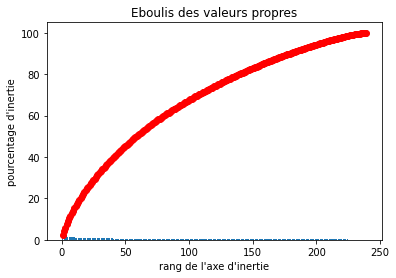

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(random_state=42)
pca.fit(X_train)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

display_scree_plot(pca)

A défaut d’un coude significatif dans la visualisation l’éboulis des composantes principales, nous utilisons un hyper paramètre consistant à retenir un nombre de vecteurs permettant de conserver 85% d’inertie.

In [19]:
import pickle 

pca = PCA(n_components=0.85, random_state=42)
pca.fit(X_train)
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)
print(f"Nombre de composantes principales: {pca.components_.shape[0]}")

filename_pca_model = './models/pca_model.pkl'
pickle.dump(pca, open(filename_pca_model, 'wb'))

Nombre de composantes principales: 159


### Vectorisaton des labels

A l’image des documents nous avons besoin de vectoriser les tags – labels afin d’entrainer les modèles. Scikit-learn fournit un module permettant de prendre en charge l’opération.

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle 

mlb = MultiLabelBinarizer(classes=first_200_tags)
train_labels = mlb.fit_transform(y_train)
test_labels = mlb.transform(y_test)

print("Affichage des classes du modèle de vectorisation")
display(mlb.classes_)

filename_mlb_model = './models/mlb_model.pkl'
pickle.dump(mlb, open(filename_mlb_model,'wb'))

Affichage des classes du modèle de vectorisation


array(['python', 'android', 'javascript', 'reactjs', 'react', 'flutter',
       'java', 'studio', 'docker', 'node', 'google', 'spring', 'angular',
       'core', 'typescript', 'visual', 'azure', 'amazon', 'native',
       'dart', 'laravel', 'code', 'firebase', 'kubernetes', 'kotlin',
       'service', 'boot', 'cloud', 'window', 'swift', 'next', 'github',
       'macos', 'xcode', 'html', 'compose', 'linux', 'tensorflow',
       'gradle', 'material', 'panda', 'django', 'hook', 'ubuntu',
       'jetpack', 'swiftui', 'apache', 'testing', 'server', 'json',
       'data', 'webpack', 'blazor', 'framework', 'router', 'selenium',
       'redux', 'navigation', 'chrome', 'mysql', 'apple', 'postgresql',
       'learning', 'discord', 'jestjs', 'vuejs', 'pytorch', 'kera',
       'function', 'mongodb', 'authentication', 'rust', 'jupyter',
       'express', 'form', 'devops', 'gitlab', 'terraform', 'powershell',
       'ruby', 'image', 'pipeline', 'maven', 'http', 'component',
       'action', 'library

### Fonction d'évaluation des modèles

Afin de comparer les modèles nous avons évalué quatre indicateurs :
- Précision : capacité à prédire correctement les tags associés à chaque document
- Recall : capacité à retourner pour chaque tags tous les documents qui y sont associés
- F1 Score : moyenne harmonique de ces deux indicateurs

Etant face à une classification multi-classes nous utilisons les version micro de ces indicateurs. Concrètement, cette version des indicateurs est calculée par classe puis agrégés là où les indicateurs macro sont calculés globalement. Lors de l’évaluation nous nous intéressons à la précision et au temps d’entraînement. Dans le cadre d’une API de suggestion de tags, la capacité d’un modèle à retourner tous les documents associés à chaque terme n’est pas essentielle. Le recall et le F1 score seront toutefois été observés pour affiner l’analyse. 


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

models_performance = {}

def metrics_report(model_name, test_labels, predictions, performances):
    """
    Compute performance metrics of a model and store them in a dictionary
    
    Args:
        model_name(string): name of the evaluated model
        test_labels(array): labels related to predictors
        preductions(array): predicted results
        performances(dict): used dictionary to store metrics
    Returns:
        performances(dict): used dictionary to store metrics filed with models ones
    """    
    accuracy = accuracy_score(test_labels, predictions)
    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + model_name + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    
    performances[model_name] = {}
    performances[model_name]["micro_precision"] =  micro_precision
    performances[model_name]["micro_recall"] = micro_recall
    performances[model_name]["micro_f1"] = micro_f1
    
    return performances

### KNN

In [22]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed, train_labels)
knn_predictions = knn_clf.predict(X_test_transformed)
metrics_report("knn", test_labels, knn_predictions, models_performance)

c:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------knn Model Metrics-----
Accuracy: 0.0776
Hamming Loss: 0.0109
Precision:
  - Macro: 0.3155
  - Micro: 0.6586
Recall:
  - Macro: 0.1080
  - Micro: 0.2274
F1-measure:
  - Macro: 0.1457
  - Micro: 0.3381
CPU times: total: 42.8 s
Wall time: 40.5 s


{'knn': {'micro_precision': 0.6585940127817019,
  'micro_recall': 0.22740998838559814,
  'micro_f1': 0.3380816714150048}}

### SVM

In [23]:
%%time
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

svm_clf = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svm_clf.fit(X_train_transformed, train_labels)

svm_preds = svm_clf.predict(X_test_transformed)
metrics_report("svm", test_labels, svm_preds, models_performance)

c:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------svm Model Metrics-----
Accuracy: 0.0999
Hamming Loss: 0.0100
Precision:
  - Macro: 0.2798
  - Micro: 0.7990
Recall:
  - Macro: 0.1000
  - Micro: 0.2520
F1-measure:
  - Macro: 0.1287
  - Micro: 0.3832
CPU times: total: 3.41 s
Wall time: 31.9 s


{'knn': {'micro_precision': 0.6585940127817019,
  'micro_recall': 0.22740998838559814,
  'micro_f1': 0.3380816714150048},
 'svm': {'micro_precision': 0.7989690721649485,
  'micro_recall': 0.25203252032520324,
  'micro_f1': 0.3831891223733004}}

### Random Forest

In [24]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train_transformed, train_labels)
rf_preds = rf_clf.predict(X_test_transformed)
metrics_report("Random Forest", test_labels, rf_preds, models_performance)

c:\Python3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


------Random Forest Model Metrics-----
Accuracy: 0.0505
Hamming Loss: 0.0110
Precision:
  - Macro: 0.1664
  - Micro: 0.8458
Recall:
  - Macro: 0.0341
  - Micro: 0.1325
F1-measure:
  - Macro: 0.0510
  - Micro: 0.2291
CPU times: total: 21min 18s
Wall time: 3min 8s


{'knn': {'micro_precision': 0.6585940127817019,
  'micro_recall': 0.22740998838559814,
  'micro_f1': 0.3380816714150048},
 'svm': {'micro_precision': 0.7989690721649485,
  'micro_recall': 0.25203252032520324,
  'micro_f1': 0.3831891223733004},
 'Random Forest': {'micro_precision': 0.8458117123795404,
  'micro_recall': 0.13252032520325202,
  'micro_f1': 0.22913947183452152}}

### Gradient boosting

In [25]:
'''%%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

gb_clf = OneVsRestClassifier(GradientBoostingClassifier())
gb_clf.fit(X_train_transformed, train_labels)
gb_preds = gb_clf.predict(X_test_transformed)
metrics_report("Gradient Boosting", test_labels, gb_preds, models_performance)'''

'%%time\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.multiclass import OneVsRestClassifier\n\ngb_clf = OneVsRestClassifier(GradientBoostingClassifier())\ngb_clf.fit(X_train_transformed, train_labels)\ngb_preds = gb_clf.predict(X_test_transformed)\nmetrics_report("Gradient Boosting", test_labels, gb_preds, models_performance)'

### Synthèse des résultats

In [26]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
result_df

,micro_precision,micro_recall,micro_f1
knn,0.658594,0.227410,0.338082
svm,0.798969,0.252033,0.383189
Random Forest,0.845812,0.132520,0.229139


Si la Random Forest offre la meilleur précision (7 points supérieure à la SVM), le modèle a un ordre de grandeur de temps d’entrainement significativement plus grand (8 fois plus long que la SVM). Si ce critère n’est pas pénalisant à l’échelle des données utilisée pour les travaux, il pourrait le devenir à une échelle plus importante. Pour cette raison nous avons sélectionné la SVM pour cette approche.

A noter que pour les besoins de l’approche supervisée, nous avons besoins d’entraîner et de maintenir quatre modèles : un vectoriseur de documents, une ACP, un vectoriseur de tags et le modèle supervisé. Il a également été nécessaire de nettoyer les tags et supprimer les documents ne correspondant pas au top 200 tags. 

Nous sauvegardons le modèle de SVM retenu.


In [27]:
import pickle
filename_svm_model = './models/svm_model.pkl'
pickle.dump(svm_clf, open(filename_svm_model,'wb'))

### Fonction de prédiction

 Afin de filtrer les tags suggérés nous avons également ajouté un filtre à la fonction de prédiction. Celui-ci consiste à parcourir le document ayant servi à la prédiction et de ne garder que les tags prédits y figurant. 

In [28]:
%%time
def predict_supervised_tags(supervised_model, mlb_model, text):
    """
    Predict tags according to a lemmatized text using a supervied model.
    
    Args:
        supervised_model(): Used mode to get prediction
        mlb_model(): Used model to detransform
    Returns:
        res(list): List of predicted tags
    """
    res = tfidf_vectorizer.transform(text)
    res = pd.DataFrame(res.toarray(), columns=vocabulary)
    res = pca.transform(res)
    res = supervised_model.predict(res)
    res = mlb.inverse_transform(res)
    res = list({tag for tag_list in res for tag in tag_list if (len(tag_list) != 0)})
    res = [tag for tag  in res if tag in text]
    
    return res

CPU times: total: 0 ns
Wall time: 0 ns


### Fonction de vérification

Afin de comparer les tags prédits et les tags renseignés par les utilisateurs, nous réalisons une fonction de vérification.

In [29]:
def check_tag_predction(original_text, original_tags, preprocessed_text, model):
    """
    Check original tags vs predicted tags for a post.
    
    Args:
        post(list) : original text
        original_tags(list) : preprocessed_tags
    """
    
    predicted_tags = predict_supervised_tags(model, mlb, preprocessed_text)
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"Liste des tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle: {predicted_tags}")

check_tag_predction(filtered_tokenized_vs_original.loc[0,'Post'], 
                filtered_tokenized_vs_original.loc[0,'splitted_tags'],
                filtered_tokenized_vs_original.loc[0,'splitted_text'],
                svm_clf)

Publication originale: 

Support for password authentication was removed. Please use a personal access token instead <p>I got this error on my console when I tried to use <code>git pull</code>:</p>
<blockquote>
<p>remote: Support for password authentication was removed on August 13, 2021. Please use a personal access token instead.<br />
remote: Please see <a href="https://github.blog/2020-12-15-token-authentication-requirements-for-git-operations/" rel="noreferrer">https://github.blog/2020-12-15-token-authentication-requirements-for-git-operations/</a> for more information.<br />
fatal: unable to access &quot;...&quot; : The requested URL returned error: 403</p>
</blockquote>
<p>It's very weird, because I just followed the documentation and created a token two weeks ago on GitHub. The token expires on Tue, Oct 26, 2021. Why has this been removed today?</p>



Liste des tags pré-traités utilisés par l'utilisateur: ['github', 'github', 'pull', 'personal', 'access', 'token']


Liste des 

## Méthode non supervisée

Nous allons utiliser un modèle LDA (Latent Dirichlet Allocation) pour cette approche. Le modèle permet de générer à partir d'un nombre k restreint de topics, une distribution de topic par document et une distribution de topic par token. Nous utilisons le module LdaMulticore de Gensim qui permet de paralléliser les calculs.

### Recherche du modèle ayant l'indice de cohérence maximum

Le modèle nécessité de définir le nombre de topics que nous souhaitons générer. Pour se faire nous observons le score de cohérence pour un ensemble de modèles LDA entrainés avec de 2 à 50 topics en hyperparamètre. L’indicateur mesure le degré de similitude sémantique des mots les plus représentés pour chaque topic. Il détermine ainsi si chaque topic est cohérent d’un point de vue sémantique ou s’il est un amalgame aléatoire de mots. Plus le score est élevé et plus le topic est cohérent. Voici diagramme d’évolution du score de cohérence par nombre de topics.

In [30]:
	
from collections.abc import Mapping

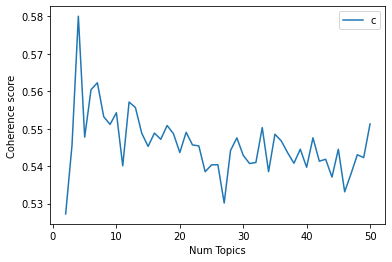

Num Topics = 2  has Coherence Value of 0.5272
Num Topics = 3  has Coherence Value of 0.5456
Num Topics = 4  has Coherence Value of 0.58
Num Topics = 5  has Coherence Value of 0.5477
Num Topics = 6  has Coherence Value of 0.5604
Num Topics = 7  has Coherence Value of 0.5623
Num Topics = 8  has Coherence Value of 0.5532
Num Topics = 9  has Coherence Value of 0.5511
Num Topics = 10  has Coherence Value of 0.5543
Num Topics = 11  has Coherence Value of 0.5401
Num Topics = 12  has Coherence Value of 0.5571
Num Topics = 13  has Coherence Value of 0.5557
Num Topics = 14  has Coherence Value of 0.5488
Num Topics = 15  has Coherence Value of 0.5453
Num Topics = 16  has Coherence Value of 0.5488
Num Topics = 17  has Coherence Value of 0.5472
Num Topics = 18  has Coherence Value of 0.5508
Num Topics = 19  has Coherence Value of 0.5487
Num Topics = 20  has Coherence Value of 0.5436
Num Topics = 21  has Coherence Value of 0.549
Num Topics = 22  has Coherence Value of 0.5457
Num Topics = 23  has Coh

In [31]:
%%time 

import gensim
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Args:
  
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

    Returns:
    
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    
    for num_topics in range(start, limit, step):
        
        model = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics, 
                            random_state=42,
                            passes=10,
                            workers=7)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

data = pd.read_pickle("./data/cleaned_corpus.pkl")
texts = data['splitted_text'].to_list()
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=1000)
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=1)


limit=51; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

L’entrainement de l’ensemble des modèles a pris 1 h 18 minutes et 2 seconds soit environs 30 secondes par modèle.  Nous constatons que la cohérence maximale (0.5513) est atteinte avec 50 topics.

### Indices de log perplexité, de cohérence et du top 20 des tags les plus représentés par topic. 

In [32]:
%%time
from pprint import pprint
optimal_model = model_list[5]

print('\nPerplexity: ', optimal_model.log_perplexity(tfidf_corpus))

coherence_model_lda = CoherenceModel(model=optimal_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))


Perplexity:  -5.241664715215457

Coherence Score:  0.5622517062404714
[(0,
  '0.060*"python" + 0.052*"file" + 0.043*"command" + 0.039*"error" + '
  '0.038*"line" + 0.037*"install" + 0.033*"version" + 0.033*"project" + '
  '0.028*"studio" + 0.026*"path" + 0.025*"script" + 0.025*"environment" + '
  '0.024*"package" + 0.021*"build" + 0.020*"code" + 0.019*"module" + '
  '0.018*"help" + 0.016*"anyone" + 0.015*"problem" + 0.015*"test" + '
  '0.015*"process" + 0.014*"root" + 0.014*"issue" + 0.013*"http" + '
  '0.013*"please" + 0.013*"image" + 0.012*"system" + 0.012*"home" + '
  '0.012*"import" + 0.012*"name"'),
 (1,
  '0.061*"time" + 0.052*"size" + 0.042*"page" + 0.037*"number" + 0.036*"code" '
  '+ 0.033*"message" + 0.032*"work" + 0.032*"example" + 0.030*"user" + '
  '0.027*"question" + 0.027*"something" + 0.025*"problem" + 0.024*"create" + '
  '0.023*"solution" + 0.022*"text" + 0.022*"context" + 0.020*"application" + '
  '0.017*"change" + 0.016*"function" + 0.016*"case" + 0.016*"class" + '

Nous constatons un nombre important de tags génériques dans ceux les plus représentés.

### Test du topic dominant, des mots clés associés des documents du corpus

In [33]:
%%time

original_post = data['Post']
original_cleaned_keywords = data['splitted_tags']

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=tfidf_corpus, texts=original_post)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


CPU times: total: 18min 6s
Wall time: 18min 36s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0.0,4.0,0.7100,"request, client, http, response, access, servi...",Support for password authentication was remove...,"[github, github, pull, personal, access, token]"
1,1.0,0.0,0.7297,"python, file, command, error, line, install, v...",NaN,NaN
2,2.0,3.0,0.6589,"react, import, component, index, export, const...","Xcode building for iOS Simulator, but linking ...","[xcode, xcode, xcode, beta, xcode, beta]"
3,3.0,3.0,0.7698,"react, import, component, index, export, const...","Error message ""error:0308010C:digital envelope...","[node, reactjs, webpack, webstorm]"
4,4.0,0.0,0.7535,"python, file, command, error, line, install, v...",Attempted import error: 'Switch' is not export...,[reactjs]
5,5.0,0.0,0.7580,"python, file, command, error, line, install, v...",Unable to resolve dependency tree error when i...,"[angularjs, angular, typescript, angular]"
6,6.0,2.0,0.5548,"java, version, android, system, google, core, ...","Android Studio error ""Installed Build Tools re...","[android, android, studio, android, emulator, ..."
7,7.0,6.0,0.5703,"image, function, const, state, button, class, ...",No Firebase App '[DEFAULT]' has been created -...,"[firebase, flutter, android, studio, dart, goo..."
8,8.0,0.0,0.7827,"python, file, command, error, line, install, v...","OnActivityResult method is deprecated, what is...","[android, android, fragment, android, activity..."
9,9.0,3.0,0.7331,"react, import, component, index, export, const...",`npm install` fails on node-gyp rebuild with `...,"[node, terminal, macos, catalina, node]"


### Document le plus significatif par topic

In [34]:
%%time

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

CPU times: total: 78.1 ms
Wall time: 93 ms


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8513,"python, file, command, error, line, install, v...",pyarrow.lib.ArrowInvalid: ('Could not convert ...
1,1.0,0.8367,"time, size, page, number, code, message, work,...",How to execute slickNext method in react-slick...
2,2.0,0.8493,"java, version, android, system, google, core, ...",Pandas DataFrame to Excel cell alignment <p>I ...
3,3.0,0.8443,"react, import, component, index, export, const...",Timestamp object has no attribute dt <p>I am t...
4,4.0,0.8636,"request, client, http, response, access, servi...",how to fix npm audit error with loadVirtual an...
5,5.0,0.8368,"value, list, print, name, input, type, import,...","Using Flutter Downloader plugin, after downloa..."
6,6.0,0.8382,"image, function, const, state, button, class, ...",Forcing a function to wait until another funct...


### Répartition des topics

Nous appréhendons tout d'abord la répartition des topics à l'aide d'un tableau;

In [35]:
%%time 
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop

CPU times: total: 0 ns
Wall time: 26 ms


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"python, file, command, error, line, install, v...",4191,0.2253
1.0,1.0,"time, size, page, number, code, message, work,...",2438,0.1311
2.0,2.0,"java, version, android, system, google, core, ...",2268,0.1219
3.0,3.0,"react, import, component, index, export, const...",2310,0.1242
4.0,4.0,"request, client, http, response, access, servi...",2654,0.1427
5.0,5.0,"value, list, print, name, input, type, import,...",2370,0.1274
6.0,6.0,"image, function, const, state, button, class, ...",2368,0.1273


Nous ajoutons une visualisation spaciale des topics.

In [36]:
%%time

from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, tfidf_corpus, id2word)
pyLDAvis.save_html(vis, 'lda_tfidf.html')
display(HTML('lda_tfidf.html'))

c:\Python3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
c:\Python3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: total: 9.56 s
Wall time: 23.5 s


En observant le tableau et le diagramme nous voyons que les documents sont répartis de manière assez égale hormis le topic 6 (sous-représenté à 12.6% of tokens) et le topic 1 (sur-représenté à 19.3% of tokens). Hormis le topic 1, des noms de technologies font partie des dix mots clés les plus représentés. 

Nous constatons cependant un nombre important de mots clés génériques associés à chaque topic comme par exemple error, number ou class. Enfin, les topics 7 et 5 ont de petites zones de recoupement.

### Fonction de prédiction

La fonction de prédiction des tags que nous avons construisons retourne les 20 mots les plus représentés du topic le plus représenté du texte soumis au modèle. A l’image de l’approche supervisée nous filtrons les résultats en ne gardant que les mots clés présents dans le texte soumis. 

A noter que l’approche non supervisée ne nécessite que de maintenir, en plus du TF-IDF le modèle LDA ainsi qu’un vocabulary (dictionnaire de correspondance) lié au corpus.

In [37]:
lda_model = optimal_model
def predict_unsupervised_tags(text):
    """
    Predict tags of a preprocessed text
    
    Args:
        text(list): preprocessed text
        
    Returns:
        relevant_tags(list): list of tags
    """
    
    corpus_new = id2word.doc2bow(text)
    topics = lda_model.get_document_topics(corpus_new)
    
    #find most relevant topic according to probability
    relevant_topic = topics[0][0]
    relevant_topic_prob = topics[0][1]
    
    for i in range(len(topics)):
        if topics[i][1] > relevant_topic_prob:
            relevant_topic = topics[i][0]
            relevant_topic_prob = topics[i][1]
            
    #retrieve associated to topic tags present in submited text
    potential_tags = lda_model.get_topic_terms(topicid=relevant_topic, topn=20)
    
    relevant_tags = [id2word[tag[0]] for tag in potential_tags if id2word[tag[0]] in text]
    
    return relevant_tags

### Fonction de vérification

Nous mettons à jour la fonction de vérification afin de comparer pour un document les tags renseignés par les utilisateurs et ceux prédit par les approches supervisées et non supervisée. 

Nous la testons sur les premiers documents du corpus.

In [38]:
def check_tag_predction(original_text, original_tags, preprocessed_text, supervised_model):
    """
    Check original tags vs predicted tags for a post.
    
    Args:
        post(list) : original text
        original_tags(list) : preprocessed_tags
    """
    
    predicted_supervised_tags = predict_supervised_tags(supervised_model, mlb, preprocessed_text)
    predicted_unsupervised_tags = predict_unsupervised_tags(preprocessed_text)
    print("Publication originale: \n")
    print(f"{original_text}")
    print("\n")
    print(f"Liste des tags pré-traités utilisés par l'utilisateur: {original_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle supervisé: {predicted_supervised_tags}")
    print("\n")
    print(f"Liste des tags prédits par le modèle non supervisé: {predicted_unsupervised_tags}")

print("Test des 10 premiers documents du corpus\n")
for i in range(10):
    print(f"Document {i}:")
    print("\n")
    check_tag_predction(filtered_tokenized_vs_original.loc[i,'Post'], 
                    filtered_tokenized_vs_original.loc[i,'splitted_tags'],
                    filtered_tokenized_vs_original.loc[i,'splitted_text'],
                    svm_clf)
    print("-"*100 + "\n")

Test des 10 premiers documents du corpus

Document 0:


Publication originale: 

Support for password authentication was removed. Please use a personal access token instead <p>I got this error on my console when I tried to use <code>git pull</code>:</p>
<blockquote>
<p>remote: Support for password authentication was removed on August 13, 2021. Please use a personal access token instead.<br />
remote: Please see <a href="https://github.blog/2020-12-15-token-authentication-requirements-for-git-operations/" rel="noreferrer">https://github.blog/2020-12-15-token-authentication-requirements-for-git-operations/</a> for more information.<br />
fatal: unable to access &quot;...&quot; : The requested URL returned error: 403</p>
</blockquote>
<p>It's very weird, because I just followed the documentation and created a token two weeks ago on GitHub. The token expires on Tue, Oct 26, 2021. Why has this been removed today?</p>



Liste des tags pré-traités utilisés par l'utilisateur: ['github', 'gith

KeyError: 1

In [ ]:
import pickle 

filename_model = './models/lda_model.pkl'
pickle.dump(lda_model, open(filename_model,'wb'))

filename_dictionary = './models/dictionary.pkl'
pickle.dump(id2word, open(filename_dictionary,'wb'))